In [51]:
import pandas as pd
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils import resample
from seaborn import clustermap
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns 
import re
import numpy as np
import scipy

sns.set()

Notebook content:
<ul>
    <li>Scaling predictions between 0 - 1</li>
    <li>Plotting prediction scores for all tools</li>
    <li>Precision recall plots</li>
    <li>Comparing performance in different genomic regions</li>
    <li>Comparing performance for different allele frequencies</li>
    <li>Balancing the data for ROC AUC comparison</li>
    <li>Score correlations</li>
</ul>

In [52]:
data = pd.read_csv('../data/data_noncoding.nctools-predictions.txt', sep='\t')
data.shape

(88892, 177)

In [53]:
data = data.rename(columns={'RawScore': 'CADD_score'})

In [54]:
# cols_scores = [x for x in data.columns if re.search(r'NCBoost_Score|NCBoost_precomputed_score|NCBoost_precomputed_chr|DeepSEA|ReMM|Eigen|LINSIGHT', x)]
cols_scores = [x for x in data.columns if re.search(r'CADD|NCBoost_Score|NCBoost_precomputed_score|NCBoost_precomputed_chr|DeepSEA|ReMM|Eigen|LINSIGHT', x)]
print(len(cols_scores))
cols_scores

16


['CADD_score',
 'ReMM_score',
 'NCBoost_Score',
 'NCBoost_Score-merged-chrom-pos',
 'NCBoost_precomputed_score',
 'NCBoost_precomputed_chr_rank_perc',
 'NCBoost_precomputed_score-merged-chrom-pos',
 'NCBoost_precomputed_chr_rank_perc-merged-chrom-pos',
 'DeepSEA_Functional_significance_score',
 'Eigen_raw',
 'Eigen-phred',
 'Eigen PC_raw',
 'Eigen PC-phred',
 'Eigen_raw-merged-chr-pos',
 'Eigen PC_raw-merged-chr-pos',
 'LINSIGHT_score']

In [55]:
data.oldTestset.value_counts()

False    87733
True       507
Name: oldTestset, dtype: int64

In [56]:
data[['#Chrom', 'Pos', 'label'] + cols_scores].head(20)

,#Chrom,Pos,label,CADD_score,ReMM_score,NCBoost_Score,NCBoost_Score-merged-chrom-pos,NCBoost_precomputed_score,NCBoost_precomputed_chr_rank_perc,NCBoost_precomputed_score-merged-chrom-pos,NCBoost_precomputed_chr_rank_perc-merged-chrom-pos,DeepSEA_Functional_significance_score,Eigen_raw,Eigen-phred,Eigen PC_raw,Eigen PC-phred,Eigen_raw-merged-chr-pos,Eigen PC_raw-merged-chr-pos,LINSIGHT_score
0,1,21835920,Pathogenic,1.031644,0.925,0.043725,0.043725,NaN,NaN,NaN,NaN,0.052103,1.238354,16.94820,4.016659,22.9740,1.238354,4.016659,0.113951
1,1,55505180,Pathogenic,0.076294,0.611,0.271459,0.271459,NaN,NaN,NaN,NaN,0.066242,0.659571,12.95600,4.729346,25.1265,0.659571,4.729346,0.214607
2,1,113498814,Pathogenic,0.900112,0.987,0.286262,0.286262,NaN,NaN,NaN,NaN,0.002187,2.062309,29.96190,6.894449,34.0382,2.062309,6.894449,0.055969
3,1,209975332,Pathogenic,1.269303,0.931,0.233192,0.233192,NaN,NaN,NaN,NaN,0.019955,1.407326,18.67910,1.703142,16.7387,1.407326,1.703142,0.160774
4,1,209975361,Pathogenic,0.417933,0.692,0.081881,0.081881,NaN,NaN,NaN,NaN,0.033797,0.769803,13.72960,1.578439,16.3985,0.769803,1.578439,0.081169
5,1,209979367,Pathogenic,0.999522,0.921,0.161182,0.161182,NaN,NaN,NaN,NaN,0.006112,1.468657,19.47700,4.528953,24.4949,1.468657,4.528953,0.061968
6,1,209979435,Pathogenic,1.050116,0.959,0.189841,0.189841,NaN,NaN,NaN,NaN,0.002021,1.475929,19.57810,4.260180,23.6961,1.475929,4.260180,0.274090
7,1,216596610,Pathogenic,1.151921,0.913,0.257114,0.257114,NaN,NaN,NaN,NaN,0.010616,0.849738,14.25140,-0.038676,7.9590,0.849738,-0.038676,0.219858
8,1,228337561,Pathogenic,2.069852,0.997,0.467702,0.467702,0.427995,0.977008,0.427995,0.977008,0.015348,1.784597,25.38060,3.232283,20.8083,1.784597,3.232283,0.671686
9,10,27389371,Pathogenic,1.067455,0.986,0.162982,0.162982,NaN,NaN,NaN,NaN,0.007389,1.493691,4.85036,5.282147,27.0885,1.493691,5.282147,0.078774


In [57]:
data.loc[data.dataset != 'CAPICE', 'sample_weight'] = 1
data_hc = data[data.sample_weight == 1]

print('Data info')
print(data.shape)
print(data.label.value_counts())

print('\nHigh-confidence variants')
print(data_hc.shape)
print(data_hc.label.value_counts())

Data info
(88892, 177)
Benign        85783
Pathogenic     3109
Name: label, dtype: int64

High-confidence variants
(7461, 177)
Benign        6000
Pathogenic    1461
Name: label, dtype: int64


<h3>Scaling predictions between 0 - 1</h3>

To easily compare predictions with each other, scale all of them between 0 and 1. 

In [58]:
#Max values
data[cols_scores].max()

CADD_score                                            22.118392
ReMM_score                                             1.000000
NCBoost_Score                                          0.918831
NCBoost_Score-merged-chrom-pos                         0.918831
NCBoost_precomputed_score                              0.953254
NCBoost_precomputed_chr_rank_perc                      0.999986
NCBoost_precomputed_score-merged-chrom-pos             0.953254
NCBoost_precomputed_chr_rank_perc-merged-chrom-pos     0.999986
DeepSEA_Functional_significance_score                  0.804400
Eigen_raw                                              3.834147
Eigen-phred                                           53.846400
Eigen PC_raw                                          10.676047
Eigen PC-phred                                        50.580700
Eigen_raw-merged-chr-pos                               3.834147
Eigen PC_raw-merged-chr-pos                           10.676047
LINSIGHT_score                          

In [59]:
#Min values
data[cols_scores].min()

CADD_score                                           -1.351343
ReMM_score                                            0.000000
NCBoost_Score                                         0.008056
NCBoost_Score-merged-chrom-pos                        0.008056
NCBoost_precomputed_score                             0.009636
NCBoost_precomputed_chr_rank_perc                     0.000161
NCBoost_precomputed_score-merged-chrom-pos            0.009636
NCBoost_precomputed_chr_rank_perc-merged-chrom-pos    0.000161
DeepSEA_Functional_significance_score                 0.000010
Eigen_raw                                            -1.507438
Eigen-phred                                           0.000049
Eigen PC_raw                                         -0.365435
Eigen PC-phred                                        0.000089
Eigen_raw-merged-chr-pos                             -1.507438
Eigen PC_raw-merged-chr-pos                          -0.365435
LINSIGHT_score                                        0

In [60]:
scale_min_max = lambda x: (data[x] - data[x].min()) / (data[x].max() - data[x].min())
for x in cols_scores:
    if 'DeepSEA' in x:
        #The DeepSEA functional significance is an e-value, so the lower the value, the more significant. 
        #Therefore convert values to value = 1 - value to easily compare it with the other tools.
        data[x] = data[x].apply(lambda x: 1-x)
    data[x + '-scaled'] = scale_min_max(x)

<h2>Plotting prediction scores for all tools</h2>

In [61]:
def plot_scores_for_tools(df, columns, title, width=16, height=8, rename_tools=False):
    print(df.shape)
    melted_df = pd.melt(df[columns + ['label']], id_vars='label', value_vars=columns)
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    plt.suptitle(title, fontsize=24, y=1.08)
    
    sns.violinplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", split=True, cut=0, ax=axes[0])
    sns.boxplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", showfliers=False, ax=axes[1])

    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    axes[1].get_legend().remove()
    
    for ax in axes:
        ax.set(xlabel='Score', ylabel='')

    plt.tight_layout()

def plot_scores_violinplot(df, columns, title, width=16, height=8, orientation='v', lw=1):
    print(df.shape)
    melted_df = pd.melt(df[columns + ['label']], id_vars='label', value_vars=columns)
    melted_df['variable'] = melted_df.variable.apply(lambda x: x.split('_')[0])
    plt.figure(figsize=(width, height))
    print(title)
    if orientation == 'v':
        sns.violinplot(x='variable', y="value", hue='label', data=melted_df, palette="muted", split=True, cut=0, orient=orientation, linewidth=lw)
        plt.xlabel('')
        plt.ylabel('Score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    else:
        sns.violinplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", split=True, cut=0, orient=orientation, linewidth=lw)
        plt.xlabel('Score')
        plt.ylabel('')
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), facecolor='w', edgecolor='w', ncol=2)
    plt.tight_layout
    plt.savefig('../figures/benchmark_analysis/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/' + title + '.pdf', bbox_inches = "tight")


(88892, 193)


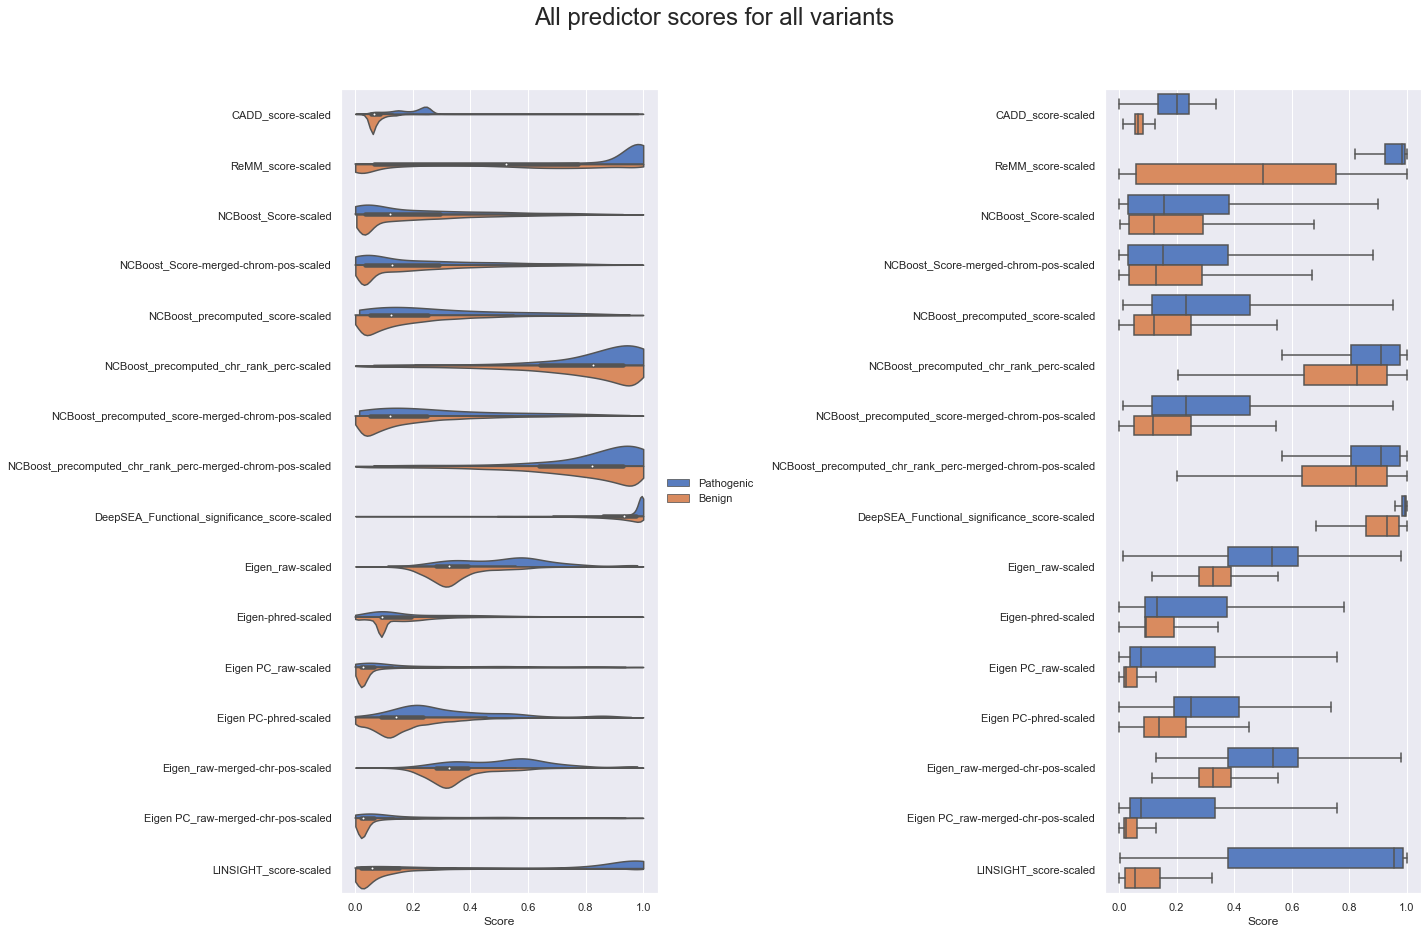

In [62]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
plot_scores_for_tools(data, columns=cols_scores_scaled, width=20, height=12, title='All predictor scores for all variants')

The tools that seem to predict well are ReMM, DeepSEA, Eigen-raw and Linsight. The only tool that does not perform well is NCBoost. It's also weird that the precomputed NCBoost score seems to be better at discriminating than the NCBoost scores obtained by utilizing the tool. 

(7461, 193)


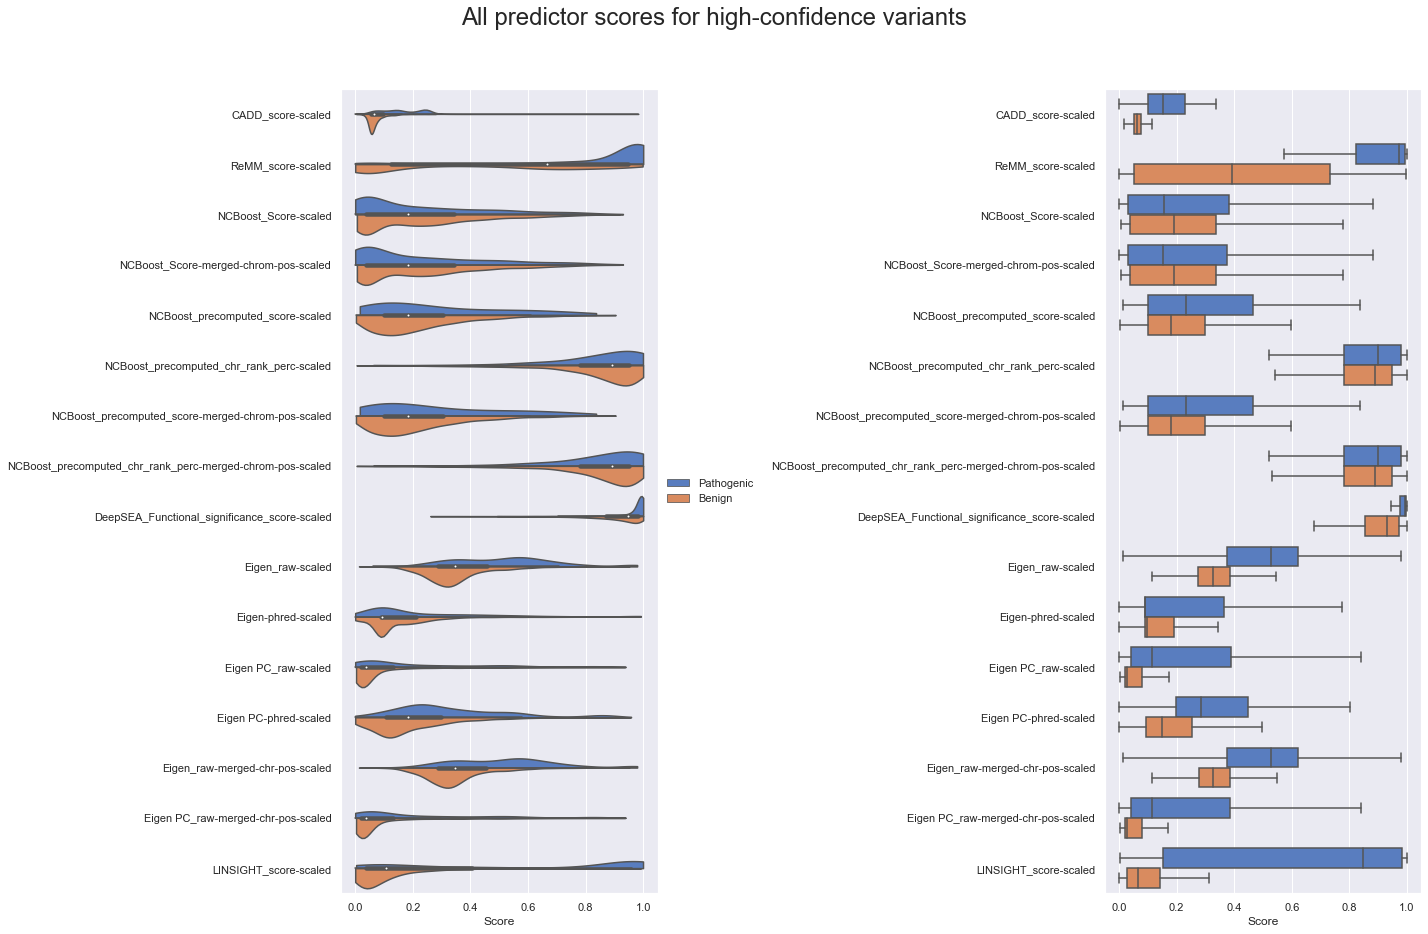

In [63]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
data_hc = data[(data.dataset == '') | (data.sample_weight == 1)]

plot_scores_for_tools(data_hc, columns=cols_scores_scaled, width=20, height=12, title='All predictor scores for high-confidence variants')

NCBoost performs worse than random here. Also interesting to see that for Eigen the pathogenic variants seem to form two distributions since Eigen is an unsupervised approach. <b>TODO:</b> investigate why Eigen predicts low scores for the left distribution. How are these variants ranked by the other tools? 

<h3>Cleaned up plots</h3>

(88892, 193)
Predictor scores for all variants V


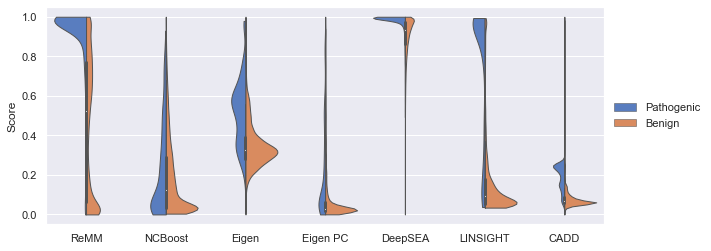

In [64]:
cols = [
    'ReMM_score-scaled',
    'NCBoost_Score-scaled',
    'Eigen_raw-scaled',
    'Eigen PC_raw-scaled',
    'DeepSEA_Functional_significance_score-scaled',
    'LINSIGHT_score',
    'CADD_score-scaled'
]

plot_scores_violinplot(data, columns=cols, width=10, height=4, title='Predictor scores for all variants V')


(7461, 193)
Predictor scores for high-confidence variants V


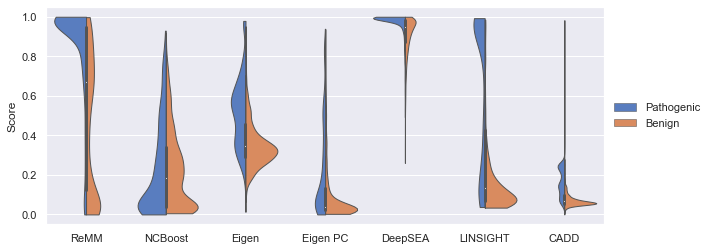

In [65]:
plot_scores_violinplot(data_hc, columns=cols, width=10, height=4, title='Predictor scores for high-confidence variants V')

(88892, 193)
Predictor scores for all variants V


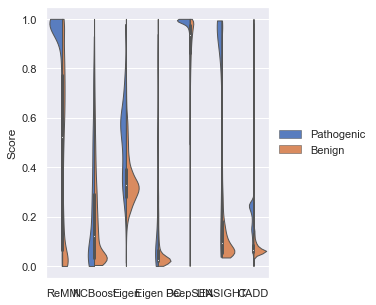

In [66]:
plot_scores_violinplot(data, columns=cols, width=4, height=5, title='Predictor scores for all variants V', lw=1)
                       

(7461, 193)
Predictor scores for high-confidence variants H


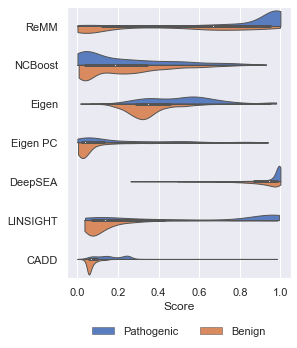

In [67]:
plot_scores_violinplot(data_hc, columns=cols, width=4, height=5, title='Predictor scores for high-confidence variants H', orientation='h', lw=1)


In [68]:
tools = ['CADD_score', 'NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw-scaled', 'Eigen PC_raw', 'LINSIGHT_score-scaled']
data_hc = data[data.sample_weight == 1]

for tool in tools:
    na = data_hc[data_hc[tool].isna()].shape[0]
    n_variants = data_hc[data_hc[tool].notna()].shape[0]
    print(tool, n_variants)
    print(data_hc[data_hc[tool].notna()]['label'].value_counts())
    print('\n')
#     print('Number of variants:', n_variants)
#     print('Number NA:', na)
#     print('\n')

CADD_score 7461
Benign        6000
Pathogenic    1461
Name: label, dtype: int64


NCBoost_Score 2047
Benign        1549
Pathogenic     498
Name: label, dtype: int64


ReMM_score 3488
Benign        2274
Pathogenic    1214
Name: label, dtype: int64


DeepSEA_Functional_significance_score 7266
Benign        5937
Pathogenic    1329
Name: label, dtype: int64


Eigen_raw-scaled 2809
Benign        2137
Pathogenic     672
Name: label, dtype: int64


Eigen PC_raw 2809
Benign        2137
Pathogenic     672
Name: label, dtype: int64


LINSIGHT_score-scaled 3226
Benign        2121
Pathogenic    1105
Name: label, dtype: int64




<h1>PR and ROC plots</h1>

Only variants that have predictions for all tools can be used for the PR plot. This decreases the number of pathogenic variants we can use. 

In [69]:
counts = lambda all_data, hc_data: pd.concat([all_data.label.value_counts().rename('All variants'), hc_data.label.value_counts().rename('High-confidence')], axis=1)

print('All data')
print(counts(data, data_hc))

print("\n\nSNV's")
print(counts(
    data[data.Ref.apply(lambda x: len(x) == 1) & data.Alt.apply(lambda x: len(x) == 1)],
    data_hc[data_hc.Ref.apply(lambda x: len(x) == 1) & data_hc.Alt.apply(lambda x: len(x) == 1)]
))

l = ['CADD_score', 'NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))

l.remove('NCBoost_Score')
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))
    

All data
            All variants  High-confidence
Benign             85783             6000
Pathogenic          3109             1461


SNV's
            All variants  High-confidence
Benign             74672             2311
Pathogenic          2822             1324


Variants that have predictions for the tools ['CADD_score', 'NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             25594             1481
Pathogenic           458              422


Variants that have predictions for the tools ['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             62656             2051
Pathogenic           833              653


If we will use all tools, only 484 pathogenic variants remain of which 439 are high-confidence. If we exclude NCBoost, 859 pathogenic variants remain of which 670 are high confidence.

In [70]:
tool_colors = {
    'NCBoost': sns.color_palette('muted')[5], 
    'ReMM': sns.color_palette('colorblind')[4], 
    'DeepSEA': sns.color_palette('colorblind')[0], 
    'Eigen': sns.color_palette('colorblind')[1], 
    'Eigen PC': sns.color_palette('colorblind')[2],
    'LINSIGHT': sns.color_palette('colorblind')[3],
    'CADD': sns.color_palette('colorblind')[6]
}

In [71]:
def plot_curve(df, cols, metric, title, auc_label='AUC'):
    values = []
    for tool in cols:
        if metric == 'pr':
            p, r, t = precision_recall_curve(df.binarized_label, df[tool])
            values.append([tool, p, r, round(average_precision_score(df.binarized_label, df[tool]), 3)])
        elif metric == 'roc':
            fpr, tpr, thresholds = roc_curve(df.binarized_label, df[tool])
            values.append([tool, tpr, fpr, round(auc(fpr, tpr), 3)])

    plt.figure(figsize=(6, 6))
    values = sorted(values, key=lambda x: x[3])[::-1]
    
    for tool in values:
        plt.plot(
            tool[2],
            tool[1], 
            color=tool_colors[re.split(r'-|_', tool[0])[0]],
            label='{} ({}: {})'.format(
                re.split(r'-|_', tool[0])[0], 
                auc_label,
                tool[3], 
            )
        )
    if metric == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    elif metric == 'roc':
        plt.plot([0, 1], [0, 1],'r--', color='gray')
        plt.xlabel('1 - Specificity (FPR)')
        plt.ylabel('Sensitivity (TPR)')
    
    plt.legend()
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.pdf', bbox_inches = "tight")

In [72]:
#Bootstrap of AP
#
#Construct each bootstrap sample by resampling n samples where n is the total 
#number of variants in the dataset.
#This will yield a dataset with varying label ratio's. 
#
#OR
#
#Construct each bootstrap sample by resampling x pathogenic samples and y 
#benign samples where x and y are the number of pathogenic and benign 
#variants respectively in the dataset.
#
#

def bootstrap_ci_ap(df, cols, ci=0.95):
    g = df.groupby('label')
    values = {}
    for i in range(1000):
        #bootstrap_sample = resample(df, replace=True, n_samples=df.shape[0])
        p = resample(g.get_group('Pathogenic'), replace=True, n_samples=g.get_group('Pathogenic').shape[0])
        b = resample(g.get_group('Benign'), replace=True, n_samples=g.get_group('Benign').shape[0])
        bootstrap_sample = pd.concat([p, b])
        
        for tool in cols:
            if tool not in values:
                values[tool] = []
            values[tool].append(round(average_precision_score(bootstrap_sample.binarized_label, bootstrap_sample[tool]), 3))
        
    d = {}
    for tool in values:
        alpha = 1-ci
        estimate = np.mean(values[tool])
        lower_bound = np.percentile(values[tool], 100*(alpha/2))
        upper_bound = np.percentile(values[tool], 100*(1-alpha/2))
        lower = estimate - lower_bound
        upper = upper_bound - estimate
        d[tool] = [estimate, lower, upper]
    return(d)


In [73]:
def plot_confidence_intervals(d, title):
    #d = dict with tools as values and [mean value, upper error, lower error] as values.  
    indices = np.argsort([s[0] for s in d.values()])[::-1]
    tools = [re.split(r'-|_', x)[0] for x in np.array(list(d.keys()))[indices]] #sort tool names on mean AP score and trim
    scores = np.array(list(d.values()))[indices]
    mean_ap = [s[0] for s in scores]
    errors = [[s[1] for s in scores], [s[2] for s in scores]]
    colors = [tool_colors[t] for t in tools]
    
    fig, axes = plt.subplots(1, 1, figsize=(2, 5))
    plotline, caps, barlinecols = plt.errorbar(x=tools, y=mean_ap, yerr=errors, ecolor=colors, linestyle='', zorder=5, elinewidth=4, solid_capstyle='round')
    for i in range(len(tools)):
        axes.scatter(x=tools[i], y=mean_ap[i], zorder=10, s=60, label=tools[i], color=colors[i])
        axes.set(ylabel='Average precision')
    
    plt.setp(barlinecols, capstyle="round", color=colors)
    axes.set_xticks([])
    axes.grid(axis='x')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.pdf', bbox_inches = "tight")


Precision recall plot for the variants for which we could retrieve predictions from all tools. 

In [74]:
def plot_benchmark_results(df, tools, variants='All-variants'):
    print(df.label.value_counts())
    p = df.label.value_counts()['Pathogenic']
    b = df.label.value_counts()['Benign']

    title = variants + '_Benign-' + str(b) + '_Pathogenic-' + str(p)

    plot_curve(metric='pr', df=df, cols=tools, auc_label='AP', title=title+'_PR')
    ap_95ci = bootstrap_ci_ap(df, cols=tools, ci=0.95)
    plot_confidence_intervals(ap_95ci, title=title+'_CI95')

    plot_curve(metric='roc', df=df, cols=tools, title=title+'_ROC')    

All tools:

Benign        25594
Pathogenic      458
Name: label, dtype: int64


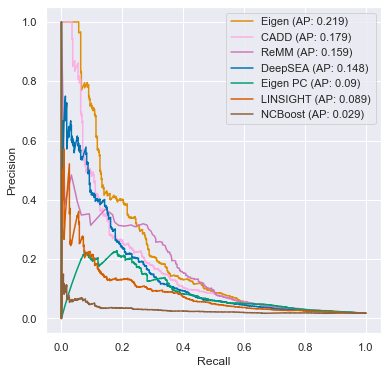

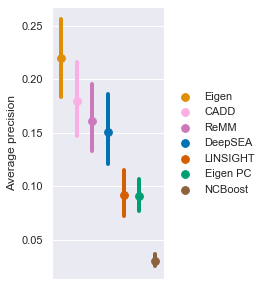

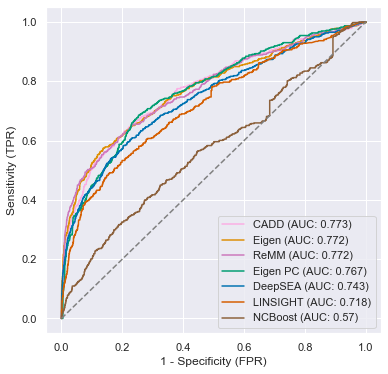

In [1634]:
tools = ['CADD_score', 'NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw-scaled', 'Eigen PC_raw', 'LINSIGHT_score-scaled']
data_filtered = data.dropna(subset=tools)
plot_benchmark_results(data_filtered, tools=tools)

Without NCBoost:

Benign        62656
Pathogenic      833
Name: label, dtype: int64


//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


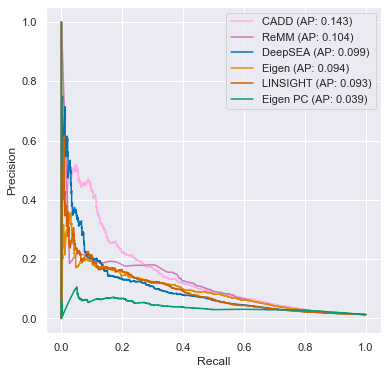

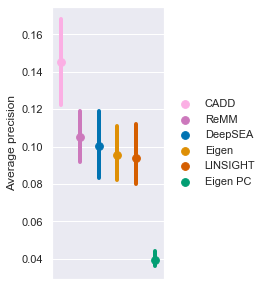

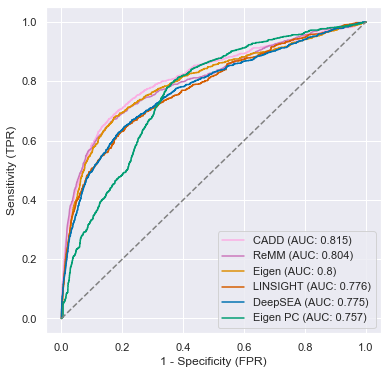

In [1635]:
tools = ['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=tools)
plot_benchmark_results(data_filtered, tools=tools)

High-confidence variants without NCBoost:

Benign        2051
Pathogenic     653
Name: label, dtype: int64


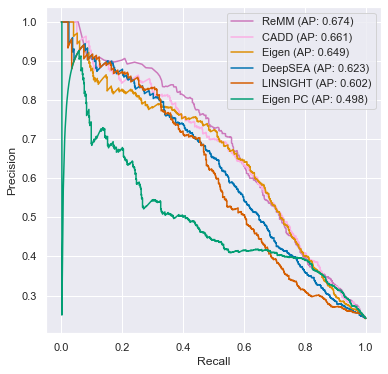

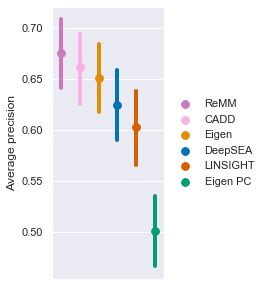

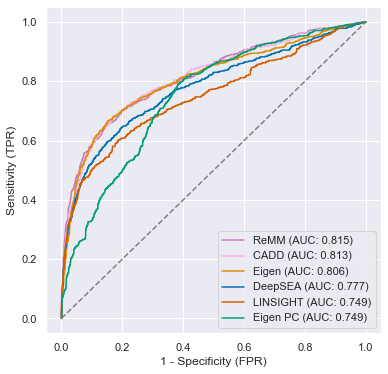

In [1636]:
tools = ['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
plot_benchmark_results(data_filtered, tools=tools, variants='HC')

High confidence variants with NCBoost included:

Benign        1481
Pathogenic     422
Name: label, dtype: int64


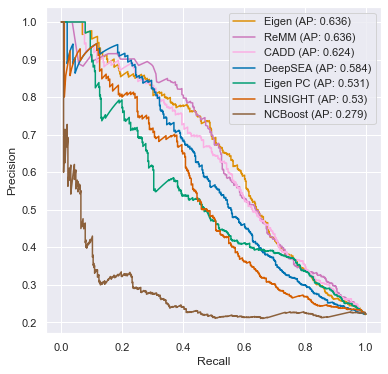

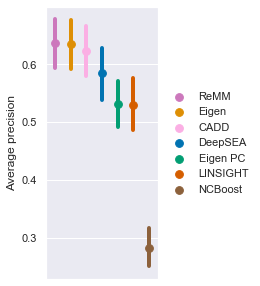

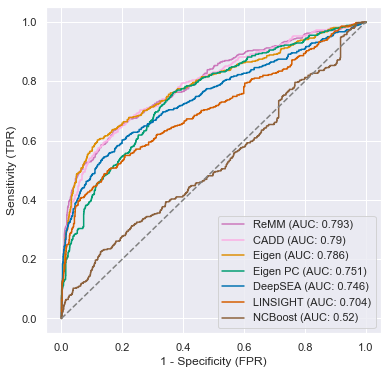

In [1637]:
tools = ['CADD_score', 'NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
plot_benchmark_results(data_filtered, tools=tools, variants='HC')

<h1>Comparing performance in different genomic regions</h1>

Do comparisons both for all data and high confidence data. Leave NCBoost out because half of the pathogenic variants don't have an NCBoost score and it doesn't perform well anyway. 

In [75]:
tools = sorted(['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])

<h3>Number of variants per region</h3>

In [76]:
print('Numbers for all variants that have predictions for all tools')
counts_regions = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.Consequence.value_counts().rename('Pathogenic'), benign_data.Consequence.value_counts().rename('Benign')], axis=1, sort=False)
data_filtered = data.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())
counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign'])


Numbers for all variants that have predictions for all tools
Benign        62656
Pathogenic      833
Name: label, dtype: int64


,Pathogenic,Benign
INTRONIC,232.0,34755.0
UPSTREAM,227.0,6729.0
5PRIME_UTR,196.0,1062.0
DOWNSTREAM,95.0,11896.0
3PRIME_UTR,59.0,7227.0
NONCODING_CHANGE,21.0,980.0
SPLICE_SITE,3.0,NaN
INTERGENIC,NaN,6.0
REGULATORY,NaN,1.0


In [77]:
print('Numbers for high-confidence variants that have predictions for all tools')
data_filtered_hc = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered_hc.label.value_counts())
counts_regions(data_filtered_hc[data_filtered_hc.label == 'Pathogenic'], data_filtered_hc[data_filtered_hc.label == 'Benign'])


Numbers for high-confidence variants that have predictions for all tools
Benign        2051
Pathogenic     653
Name: label, dtype: int64


,Pathogenic,Benign
5PRIME_UTR,196,124.0
UPSTREAM,178,57.0
INTRONIC,176,1690.0
3PRIME_UTR,57,89.0
DOWNSTREAM,37,80.0
NONCODING_CHANGE,6,11.0
SPLICE_SITE,3,NaN


<h3>Score plots per region</h3>

In [78]:
#Only use these regions as the others don't have enough variants
regions = sorted(['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR'])

In [79]:
def plot_scores_per_category_per_tool(df, col, title, nrows, ncols, figsize=(12, 8), legend_pos=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    plt.suptitle(title, fontsize=18, y=1.05)
    for i in range(len(tools)):
        tool = tools[i]
        name = re.split(r'-|_', tool)[0]
        ax0 = axes[i]
        regions = list(set(df[col]))
        sns.boxplot(
            x=tool,
            y=col,
            hue='label',
            data=df,
            palette='muted',
            showfliers=False,
            order=sorted(list(set(df[col]))),
            ax=ax0
        )
        ax0.set_title(name)  
        ax0.set(xlabel='Score', ylabel='')
        ax0.get_legend().remove()
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(legend_pos, 0.5), facecolor='w', edgecolor='w')  #bbox_to_anchor  (width, height)
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.pdf', bbox_inches = "tight")

def plot_ap_per_tool_per_category(df, col, tools, categories, rows, cols, title, figsize=(12,6)):

    df_filtered = df[df[col].isin(categories)]
    tool_names = [re.split(r'-|_', tool)[0] for tool in tools]
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.suptitle(title, fontsize=16, y=1.05)
    axes = axes.flatten()
    
    for i in range(len(categories)):
        category = categories[i]
        ax = axes[i]
        df_filtered_category = df[df[col] == category]
        aps = [average_precision_score(df_filtered_category.binarized_label, df_filtered_category[tool]) for tool in tools]
        ax.barh(y=tool_names, width=aps)
        ax.set(xlabel='Average precision')
        ax.set_title(category)     
    
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.pdf', bbox_inches = "tight")


Benign        62656
Pathogenic      833
Name: label, dtype: int64
                  Pathogenic   Benign
INTRONIC               232.0  34755.0
UPSTREAM               227.0   6729.0
5PRIME_UTR             196.0   1062.0
DOWNSTREAM              95.0  11896.0
3PRIME_UTR              59.0   7227.0
NONCODING_CHANGE        21.0    980.0
SPLICE_SITE              3.0      NaN
INTERGENIC               NaN      6.0
REGULATORY               NaN      1.0


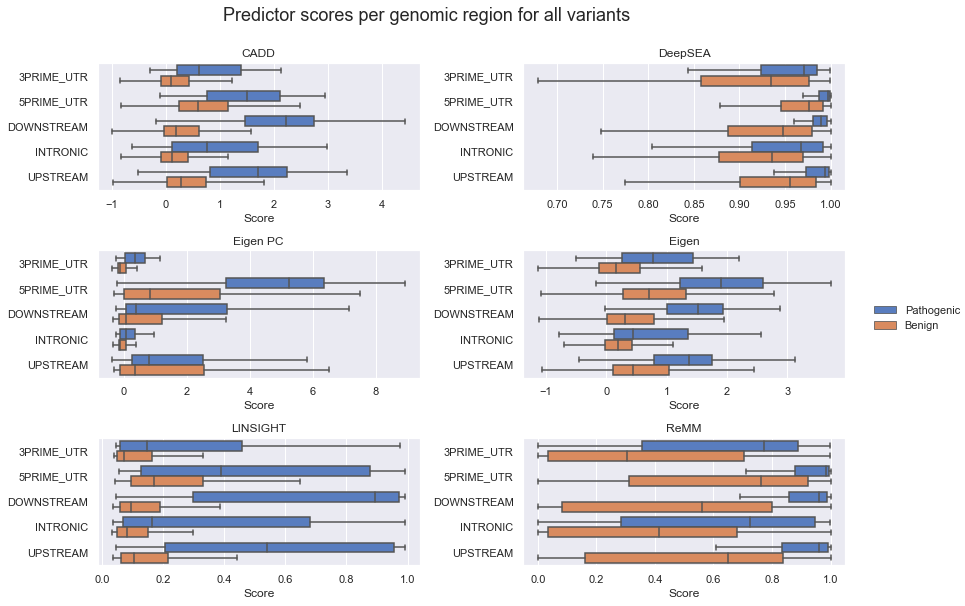

In [80]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    col='Consequence', 
    title='Predictor scores per genomic region for all variants', 
    nrows=3, ncols=2, figsize=(12,8))

Benign        2051
Pathogenic     653
Name: label, dtype: int64
                  Pathogenic  Benign
5PRIME_UTR               196   124.0
UPSTREAM                 178    57.0
INTRONIC                 176  1690.0
3PRIME_UTR                57    89.0
DOWNSTREAM                37    80.0
NONCODING_CHANGE           6    11.0
SPLICE_SITE                3     NaN


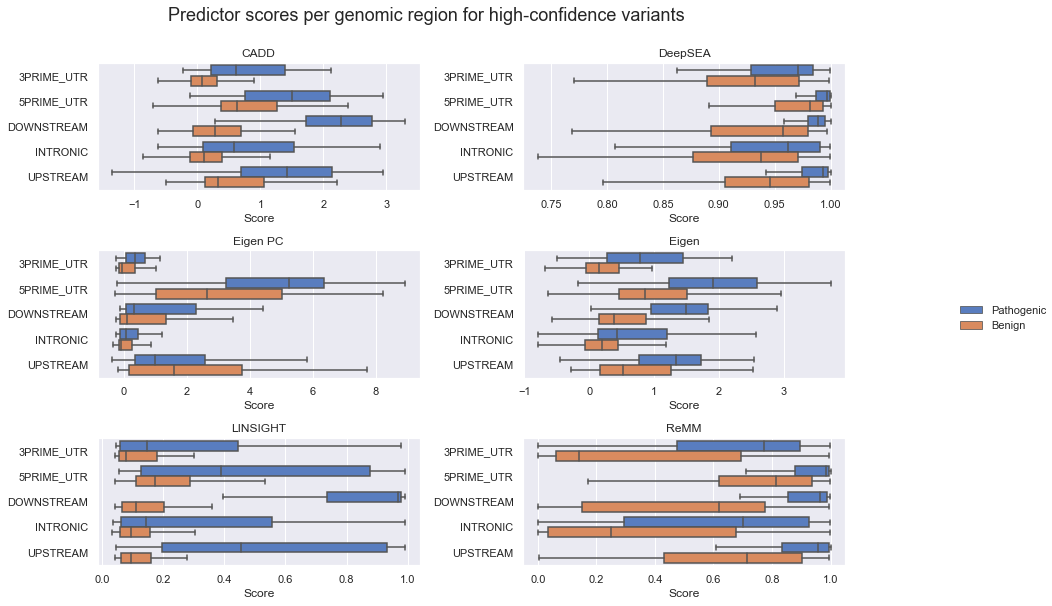

In [81]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    col='Consequence', 
    title='Predictor scores per genomic region for high-confidence variants', 
    nrows=3, ncols=2, figsize=(12,8), legend_pos=1.1)


<h3>Average precision per tool for all regions</h3>

Benign        62656
Pathogenic      833
Name: label, dtype: int64
                  Pathogenic   Benign
INTRONIC               232.0  34755.0
UPSTREAM               227.0   6729.0
5PRIME_UTR             196.0   1062.0
DOWNSTREAM              95.0  11896.0
3PRIME_UTR              59.0   7227.0
NONCODING_CHANGE        21.0    980.0
SPLICE_SITE              3.0      NaN
INTERGENIC               NaN      6.0
REGULATORY               NaN      1.0


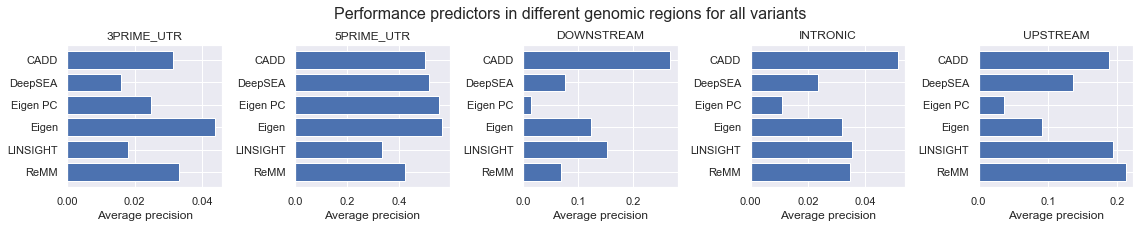

In [82]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=regions, col='Consequence', tools=tools[::-1], rows=1, cols=len(regions), figsize=(16,3), title='Performance predictors in different genomic regions for all variants') 

Because this is average precision, we can only compare the rankings of tools between regions with each other since AP is dependent on class ratio and different regions have different class ratios. 

Observations:
<ul>
    <li>LINSIGHT performs best in intronic and downstream, but worst of all tools in 5'utr and 3'utr (why could that be?).</li>
    <li>Eigen PC performs worst for intronic, upstream and downstream, good in 5'utr and average in 3'utr. </li>
    <li>Eigen performs best in 5'utr, 3'utr and intronic. Also performs good for downstream. Bad in upstream.</li>
    <li>ReMM performs best in intronic and upstream, and also good for 3'utr.</li>
    <li>DeepSEA worst in 3'utr.</li>
</ul>


Benign        2051
Pathogenic     653
Name: label, dtype: int64
                  Pathogenic  Benign
5PRIME_UTR               196   124.0
UPSTREAM                 178    57.0
INTRONIC                 176  1690.0
3PRIME_UTR                57    89.0
DOWNSTREAM                37    80.0
NONCODING_CHANGE           6    11.0
SPLICE_SITE                3     NaN


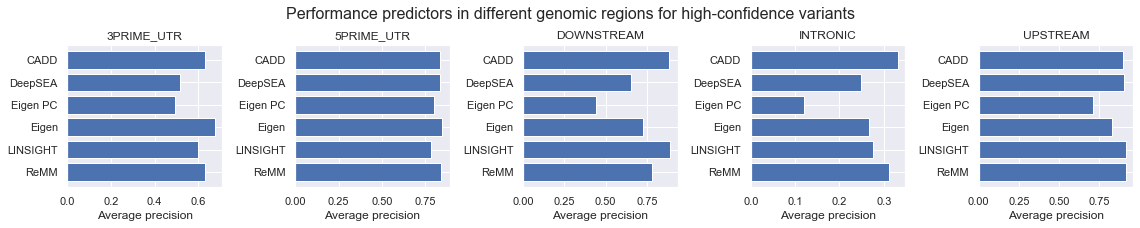

In [83]:
#Numbers for high confidence variants
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=regions, col='Consequence', tools=tools[::-1], rows=1, cols=len(regions), figsize=(16,3), title='Performance predictors in different genomic regions for high-confidence variants') 


Just as in the plot above, Eigen PC performs worst for intronic, downstream and upstream.
LInsight and ReMM best for instronic, upstream and downstream. 
Eigen best for 5'utr and 3'utr.

<h1>Comparing performance for different allele frequencies</h1>

In [84]:
# data_filtered = data.dropna(subset=tools)
bins = pd.cut(data.max_AF, [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1], include_lowest=True, right=False)
counts_af = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.bins.value_counts().rename('Pathogenic'), benign_data.bins.value_counts().rename('Benign')], axis=1, sort=False)
bins = bins.apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))
data['bins'] = bins

data_filtered = data.dropna(subset=tools)
counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign'])


,Pathogenic,Benign
0.0 - 1e-06,562,7234
1e-06 - 1e-05,19,6120
1e-05 - 0.0001,84,15610
0.0001 - 0.001,100,8492
0.001 - 0.01,57,6140
0.01 - 1.0,11,18694


In [85]:
print('Numbers for high-confidence variants that have predictions for all tools')
data_filtered_hc = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered_hc.label.value_counts())
counts_regions(data_filtered_hc[data_filtered_hc.label == 'Pathogenic'], data_filtered_hc[data_filtered_hc.label == 'Benign'])


Numbers for high-confidence variants that have predictions for all tools
Benign        2051
Pathogenic     653
Name: label, dtype: int64


,Pathogenic,Benign
5PRIME_UTR,196,124.0
UPSTREAM,178,57.0
INTRONIC,176,1690.0
3PRIME_UTR,57,89.0
DOWNSTREAM,37,80.0
NONCODING_CHANGE,6,11.0
SPLICE_SITE,3,NaN


<h3>Score plots for different AF bins<h3>

Benign        62656
Pathogenic      833
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            562    7234
1e-06 - 1e-05           19    6120
1e-05 - 0.0001          84   15610
0.0001 - 0.001         100    8492
0.001 - 0.01            57    6140
0.01 - 1.0              11   18694


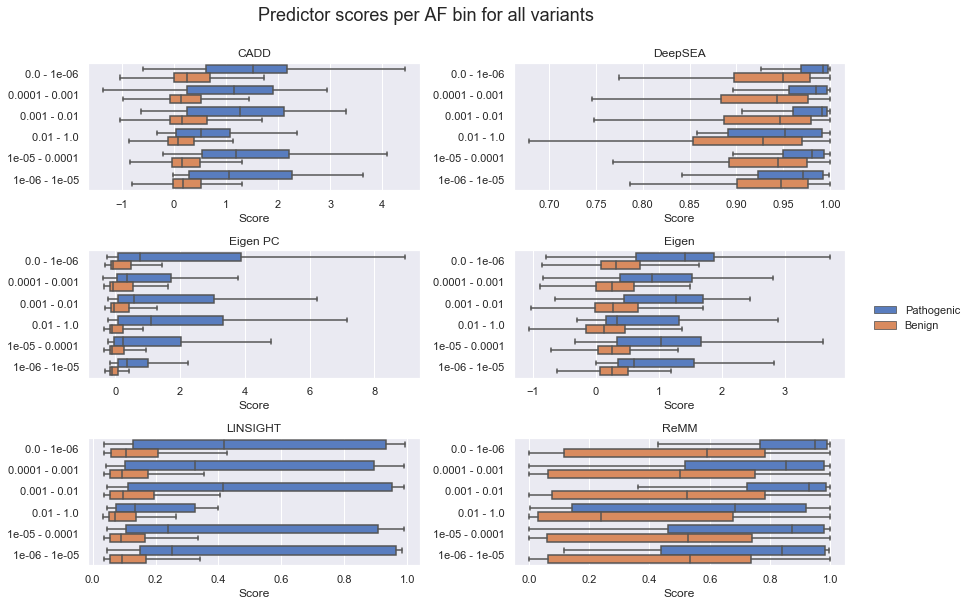

In [86]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered.dropna(subset=['bins']), 
    col='bins', 
    title='Predictor scores per AF bin for all variants', 
    nrows=3, ncols=2, figsize=(12,8))

Benign        2051
Pathogenic     653
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            447      59
1e-06 - 1e-05           13      25
1e-05 - 0.0001          58     104
0.0001 - 0.001          76      93
0.001 - 0.01            52     255
0.01 - 1.0               7    1480


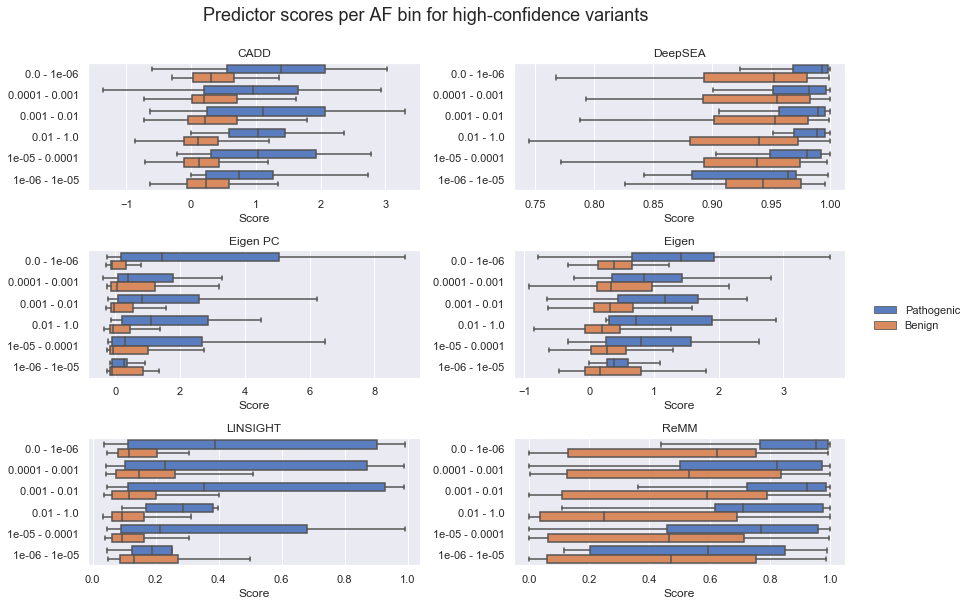

In [87]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered.dropna(subset=['bins']), 
    col='bins', 
    title='Predictor scores per AF bin for high-confidence variants', 
    nrows=3, ncols=2, figsize=(12,8))

<h3>Average precision per tool for all AF bins</h3>

Benign        62656
Pathogenic      833
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            562    7234
1e-06 - 1e-05           19    6120
1e-05 - 0.0001          84   15610
0.0001 - 0.001         100    8492
0.001 - 0.01            57    6140
0.01 - 1.0              11   18694


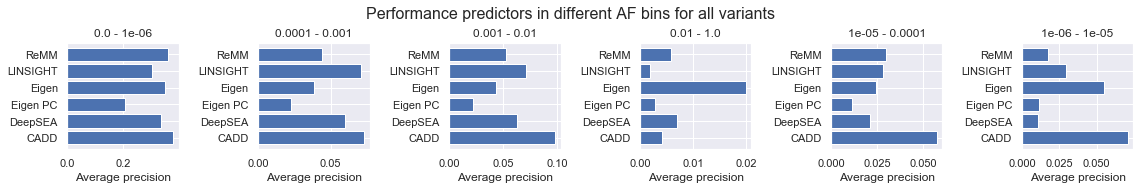

In [88]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=sorted(list(set(bins.dropna()))), col='bins', tools=tools, rows=1, cols=len(list(set(bins.dropna()))), figsize=(16,2.5), title='Performance predictors in different AF bins for all variants') 


Benign        2051
Pathogenic     653
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            447      59
1e-06 - 1e-05           13      25
1e-05 - 0.0001          58     104
0.0001 - 0.001          76      93
0.001 - 0.01            52     255
0.01 - 1.0               7    1480


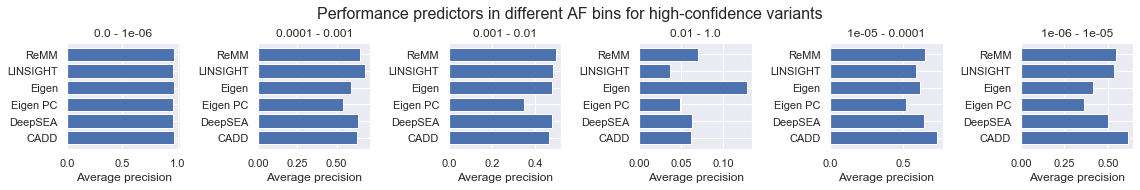

In [89]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=sorted(list(set(bins.dropna()))), col='bins', tools=tools, rows=1, cols=len(list(set(bins.dropna()))), figsize=(16,2.5), title='Performance predictors in different AF bins for high-confidence variants') 


<h1>Balancing the data for ROC AUC comparison</h1>

It's difficult to compare performance in different AF's and genomic regions because average precision is dependent on the class ratios. Therefore, do the same analyses as above but with balanced data.

In [90]:
tools = sorted(['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])
regions = sorted(['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR'])

In [148]:
def return_balanced_data(df, column, random_state):
    groups_regions = df.groupby(column, group_keys=False)
    balanced_dfs = []
    for name, df in groups_regions:
        labels = df.groupby('label', group_keys=False)
        balanced = labels.apply(lambda x: x.sample(labels.size().min(), random_state=random_state))
        balanced_dfs.append(balanced)
    balanced_df = pd.concat(balanced_dfs, axis=0)
    return balanced_df

def compute_auc_values(df, cols, categories, metric='roc'):
    #For each tool/category combination: performs bootstrapping (1000 iterations) on 
    #the pathogenic subset and on the bening subset (sample size = pathogenic subset 
    #size). Combines the two to get a randombly balanced subset for tool/category 
    #combination. Returns results in a dataframe with columns 'Tool', 'Category' and 
    #'ROC AUC'.
    all_auc_values = []
    for n, category in enumerate(list(set(df[categories]))):
        df_f = df[df[categories] == category] 
        g = df_f.groupby('label')
        n_samples = g.get_group('Pathogenic').shape[0]
        for i in range(1000):
            p = resample(g.get_group('Pathogenic'), replace=True, n_samples=n_samples)
            b = resample(g.get_group('Benign'), replace=True, n_samples=n_samples)
            balanced = pd.concat([p, b])
            for tool in cols:
                if metric == 'ap':
                    ap = average_precision_score(balanced.binarized_label, balanced[tool])
                    all_auc_values.append([tool.split('_')[0], category, round(ap, 3)])
                else:
                    fpr, tpr, t = roc_curve(balanced.binarized_label, balanced[tool], pos_label=1)
                    all_auc_values.append([tool.split('_')[0], category, round(auc(fpr, tpr), 3)])

    if metric == 'ap':
        auc_values_df = pd.DataFrame(all_auc_values, columns=['Tool', 'Category', 'AP'])
    else:
        auc_values_df = pd.DataFrame(all_auc_values, columns=['Tool', 'Category', 'ROC AUC'])
    return auc_values_df

def calculate_confidence_intervals(df, ci=0.95, metric='roc'):
    #df: tool category score
    #group.by tool/category, calculate ci
    #return dict
    #d = {tool: {intronic: [], 5utr: [], etc. }, tool2: {...} ...}
    d = {}
    for name1, group1 in df.groupby(['Tool']):
        d[name1] = {}
        for name2, group2 in group1.groupby(['Category']):
            if metric == 'ap':
                scores = group2['AP']
            else:
                scores = group2['ROC AUC']
            alpha = 1-ci
            estimate = np.mean(scores)
            lower_bound = np.percentile(scores, 100*(alpha/2))
            upper_bound = np.percentile(scores, 100*(1-alpha/2))
            lower = estimate - lower_bound
            upper = upper_bound - estimate
            d[name1][name2] = [estimate, lower, upper]
    return(d)

def plot_aucs(df, groupby, classes, title, colors, figsize, order_on='str', nplots=5):
    fig, axes = plt.subplots(1, nplots, figsize=figsize,  sharey=True)
    axes = axes.flatten()
    print(title)
    df[classes] = df[classes].apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))

    try:
        order = sorted(list(set(df[classes])), key=lambda x: float(x.split(' - ')[0]))
    except:
        order = sorted(list(set(df[classes])))
    for i, grouped in enumerate(df.groupby(groupby)):
        sns.pointplot(x=classes, y='ROC AUC', data=grouped[1], ax=axes[i], join=False, order=order, palette=colors, ci='sd', scale=0.8, n_boot=1000)
        axes[i].set_title(grouped[0])
        if i == 0:
            axes[i].set(xlabel='')
        else:
            axes[i].set(xlabel='', ylabel='')
        axes[i].set_xticks([])
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors[:len(set(df[classes]))]]
    plt.legend(handles=legend_elements, labels=order, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.png', bbox_inches='tight')
    plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.pdf', bbox_inches='tight')   

def convert_auc_dict(d):
    #Converts the dict from compute_roc_auc_values_per_tool() to:
    #{tool1: {category1: [auc values], category2: [auc values]}, tool2: {....}}
    d_converted = {}
    for category in d:
        for tool in d[category]:
            if tool not in d_converted:
                d_converted[tool] = {}
            d_converted[tool][category] = d[category][tool] 
    return d_converted

# def plot_roc_aucs(df, groupby, classes, title, colors, figsize, order_on='str', nplots=5):
#     fig, axes = plt.subplots(1, nplots, figsize=figsize,  sharey=True)
#     axes = axes.flatten()
#     print(title)
#     df[classes] = df[classes].apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))

#     try:
#         order = sorted(list(set(df[classes])), key=lambda x: float(x.split(' - ')[0]))
#     except:
#         order = sorted(list(set(df[classes])))
#     for i, grouped in enumerate(df.groupby(groupby)):
#         sns.pointplot(x=classes, y='ROC AUC', data=grouped[1], ax=axes[i], join=False, order=order, palette=colors, ci='sd', scale=0.8, n_boot=1000)
#         axes[i].set_title(grouped[0])
#         if i == 0:
#             axes[i].set(xlabel='')
#         else:
#             axes[i].set(xlabel='', ylabel='')
#         axes[i].set_xticks([])
    
#     legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors[:len(set(df[classes]))]]
#     plt.legend(handles=legend_elements, labels=order, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.png', bbox_inches='tight')
#     plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.pdf', bbox_inches='tight')

def plot_confidence_intervals(d, title, colors, figsize=(9,3), order_on=None):
    nplots = len(d.keys())
    fig, axes = plt.subplots(1, nplots, figsize=figsize,  sharey=True)
    if order_on:
        indices = np.argsort([float(n.split(' - ')[0]) for n in list(d[list(d.keys())[0]].keys())])
    else:
        indices = np.argsort([n for n in list(d[list(d.keys())[0]].keys())])
    
    for i, key in enumerate(sorted(d.keys())):
        scores = np.array(list(d[key].values()))[indices]
        labels = np.array(list(d[key].keys()))[indices]
        mean_auc = [s[0] for s in scores]
        errors = [[s[1] for s in scores], [s[2] for s in scores]]
        axes[i].set_title(key)
        for e in range(len(labels)):
            axes[i].scatter(x=labels[e], y=mean_auc[e], s=50, label=labels[e], color=colors[e])
        plotline, caps, barlinecols = axes[i].errorbar(x=labels, y=mean_auc, yerr=errors, ecolor=colors, linestyle='', zorder=5, elinewidth=3, solid_capstyle='round')
        plt.setp(barlinecols, capstyle='round')
        axes[i].set_xticks([])
        axes[i].grid(axis='x')
        if i == 0:
            axes[i].set(ylabel='ROC AUC')
     
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.pdf', bbox_inches = "tight")


<h3>Genomic regions</h3>

In [131]:
data_filtered = data.dropna(subset=tools)

balanced_regions = return_balanced_data(data_filtered[data_filtered.Consequence.isin(regions)], column='Consequence', random_state=53)
print('All variants')
counts_regions(balanced_regions[balanced_regions.label == 'Pathogenic'], balanced_regions[balanced_regions.label == 'Benign'])

All variants


,Pathogenic,Benign
INTRONIC,232,232
UPSTREAM,227,227
5PRIME_UTR,196,196
DOWNSTREAM,95,95
3PRIME_UTR,59,59


In [132]:
data_filtered_hc = data_filtered[data_filtered.sample_weight == 1]

balanced_regions_hc = return_balanced_data(data_filtered_hc[data_filtered_hc.Consequence.isin(regions)], column='Consequence', random_state=53)
print('High-confidence variants')
counts_regions(balanced_regions_hc[balanced_regions_hc.label == 'Pathogenic'], balanced_regions_hc[balanced_regions_hc.label == 'Benign'])

High-confidence variants


,Pathogenic,Benign
INTRONIC,176,176
5PRIME_UTR,124,124
3PRIME_UTR,57,57
UPSTREAM,57,57
DOWNSTREAM,37,37


Because we don't have that many pathogenic variants per region, ROC AUC values will likely be quite dependent on which benign variants were selected. Therefore, repeat dataset balancing for regions 100 times using 100 different random states. Then we can compare the tools based on the average ROC AUC. 

In [133]:
roc_auc_regions = compute_auc_values(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence')

roc_auc_regions_hc = compute_auc_values(
    data_filtered_hc[data_filtered_hc.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence')

Metric: roc
Metric: roc


In [142]:
pr_auc_regions = compute_auc_values(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence',
    metric='ap')

pr_auc_regions_hc = compute_auc_values(
    data_filtered_hc[data_filtered_hc.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence',
    metric='ap')

In [149]:
auc_ci95_regions = calculate_confidence_intervals(roc_auc_regions)
auc_ci95_regions_hc = calculate_confidence_intervals(roc_auc_regions_hc)
ap_ci95_regions = calculate_confidence_intervals(pr_auc_regions, metric='ap')
ap_ci95_regions_hc = calculate_confidence_intervals(pr_auc_regions_hc, metric='ap')

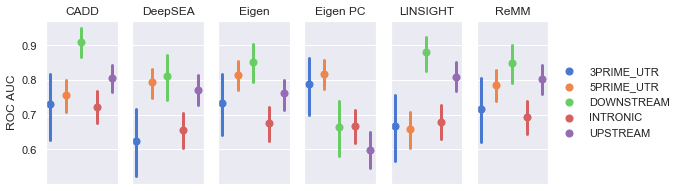

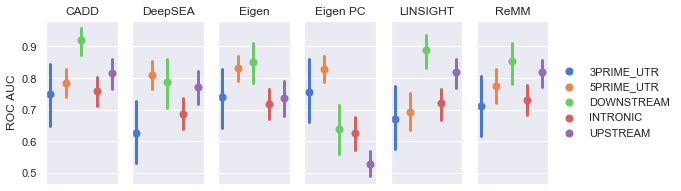

In [150]:
plot_confidence_intervals(auc_ci95_regions, colors=sns.color_palette('muted'), title='ROC AUC tools genomic regions tools all variants')
plot_confidence_intervals(ap_ci95_regions, colors=sns.color_palette('muted'), title='AP tools genomic regions tools all variants')

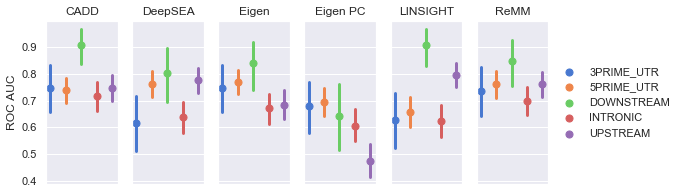

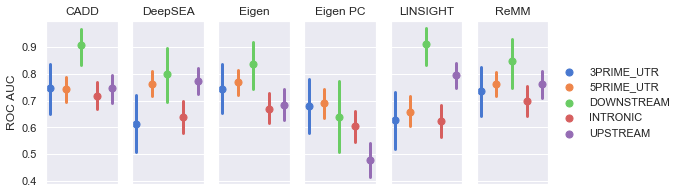

In [122]:
plot_confidence_intervals(auc_ci95_regions_hc, colors=sns.color_palette('muted'), title='ROC AUC tools genomic regions tools HC variants')
plot_confidence_intervals(ap_ci95_regions_hc, colors=sns.color_palette('muted'), title='AP tools genomic regions tools HC variants')

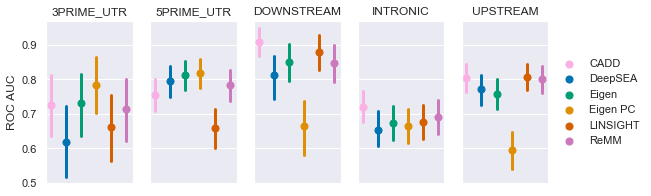

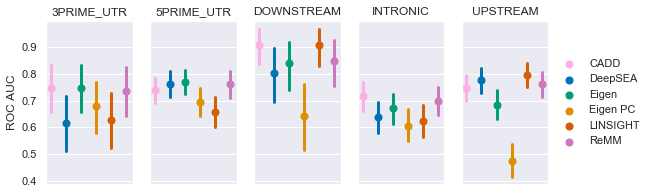

In [116]:
plot_confidence_intervals(convert_auc_dict(auc_ci95_regions), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='ROC AUC tools genomic regions tools all variants')
plot_confidence_intervals(convert_auc_dict(auc_ci95_regions_hc), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='ROC AUC tools genomic regions tools HC variants')

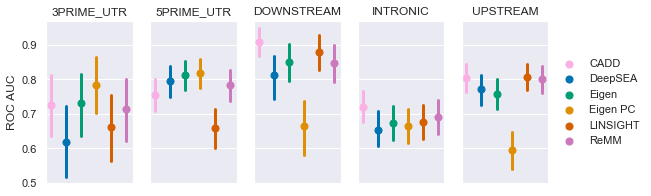

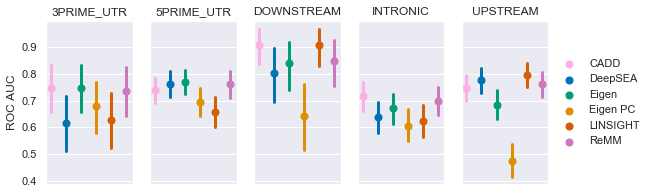

In [117]:
plot_confidence_intervals(convert_auc_dict(auc_ci95_regions), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='AP tools genomic regions tools all variants')
plot_confidence_intervals(convert_auc_dict(auc_ci95_regions_hc), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='AP tools genomic regions tools HC variants')

Comments:
For these pathogenic variants:
<ul>
    <li>No big differences in AUC between all variants and high-confidence variants.</li>
    <li>Linsight and ReMM perform best in downstream regions.</li>
    <li>Eigen PC performs best in 5'utr and 3'utr. Why could that be?</li>
    <li>ReMM, DeepSEA and Eigen perform quite consistent.</li>
</ul>

<h3>Allele frequency bins</h3>

In [118]:
data_filtered = data.dropna(subset=tools)

balanced_af = return_balanced_data(data_filtered, column='bins', random_state=53)
print('All variants')
counts_af(balanced_af[balanced_af.label == 'Pathogenic'], balanced_af[balanced_af.label == 'Benign']).sort_index()
# data_filtered[data_filtered.label == 'Pathogenic'].bins.value_counts()

All variants


,Pathogenic,Benign
0.0 - 1e-06,562,562
1e-06 - 1e-05,19,19
1e-05 - 0.0001,84,84
0.0001 - 0.001,100,100
0.001 - 0.01,57,57
0.01 - 1.0,11,11


In [119]:
data_filtered_hc = data_filtered[data_filtered.sample_weight == 1]
balanced_af_hc = return_balanced_data(data_filtered_hc, column='bins', random_state=53)
balanced_af_hc[balanced_af_hc.label == 'Pathogenic'].bins.value_counts()
print('High-confidence variants')
counts_af(balanced_af_hc[balanced_af_hc.label == 'Pathogenic'], balanced_af_hc[balanced_af_hc.label == 'Benign'])

High-confidence variants


,Pathogenic,Benign
0.0001 - 0.001,76,76
0.0 - 1e-06,59,59
1e-05 - 0.0001,58,58
0.001 - 0.01,52,52
1e-06 - 1e-05,13,13
0.01 - 1.0,7,7


In [120]:
roc_auc_af = compute_roc_auc_values_per_tool_and_category(
    data_filtered.dropna(subset=['bins']),
    cols=tools, 
    categories='bins')

roc_auc_af_hc = compute_roc_auc_values_per_tool_and_category(
    data_filtered_hc.dropna(subset=['bins']),
    cols=tools, 
    categories='bins')

NameError: name 'compute_roc_auc_values_per_tool_and_category' is not defined

In [ ]:
auc_ci95_af = calculate_confidence_intervals(roc_auc_af)
auc_ci95_af_hc = calculate_confidence_intervals(roc_auc_af_hc)

In [ ]:
plot_confidence_intervals(auc_ci95_af, colors=sns.color_palette('viridis'), title='ROC AUC tools AF bins all variants', order_on='af_bin')
plot_confidence_intervals(auc_ci95_af_hc, colors=sns.color_palette('viridis'), title='ROC AUC tools AF bins HC variants', order_on='af_bin')

In [ ]:
plot_confidence_intervals(convert_roc_auc_dict(auc_ci95_af), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='ROC AUC tools AF bins tools all variants')
plot_confidence_intervals(convert_roc_auc_dict(auc_ci95_af_hc), colors=[tool_colors[re.split(r'-|_', t)[0]] for t in tools], title='ROC AUC tools AF bins tools HC variants')


In [ ]:
tools = ['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[data_filtered.sample_weight == 1]

In [ ]:
data_filtered[(data_filtered.Consequence == 'DOWNSTREAM') & (data_filtered.label == 'Pathogenic')]['bins'].value_counts()


In [ ]:
data_filtered[(data_filtered.Consequence == '5PRIME_UTR') & (data_filtered.label == 'Pathogenic')]['bins'].value_counts()


In [ ]:
data_filtered[(data_filtered.Consequence == 'UPSTREAM') & (data_filtered.label == 'Pathogenic')]['bins'].value_counts()

In [ ]:
data_filtered[(data_filtered.Consequence == 'INTRONIC') & (data_filtered.label == 'Pathogenic')]['bins'].value_counts()

In [ ]:
data_filtered[data_filtered.label == 'Pathogenic'].Consequence.value_counts()

<h1>Predictor score correlation</h1>

In [ ]:
#correlations_matrix = nc[numerical_features].corr()
#clustermap(correlations_matrix, figsize=(13,8))
correlation_matrix = data_filtered[tools].corr()
correlation_matrix

In [ ]:
clustermap(correlation_matrix, figsize=(5,5), cmap="Reds")

In [ ]:
correlation_matrix = data_filtered[tools].corr()
correlation_matrix

In [ ]:
l = ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))

l.remove('NCBoost_Score')
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))

In [ ]:
print('HC variants in the CAPICE train and test set:')
data_hc = data[data.sample_weight == 1]
l = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print(data_hc.dropna(subset=l)[data_hc.label == 'Pathogenic']['NCBoost_data'].value_counts())

print('\nVariants from NCBoost:')
data_hc = data[data.NCBoost_data == True]
l = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print(data_hc.dropna(subset=l)[data_hc.label == 'Pathogenic']['NCBoost_data'].value_counts())

print('\nHC variants from CAPICE + NCBoost:')
data_hc = data[(data.NCBoost_data == True) | (data.sample_weight == 1)]
l = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print(data_hc.dropna(subset=l)[data_hc.label == 'Pathogenic']['NCBoost_data'].value_counts())


In [ ]:
def compute_roc_auc_values_per_tool(df, cols, categories, title):
    #Returns a dict that looks like
    #{category1: {tool1: [auc values], tool2: [auc values]}, category2: {....}}
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()
    plt.suptitle(title, fontsize=24, y=1.08)
    
    print(df[df.label == 'Pathogenic'][categories].value_counts())
    
    all_auc_values = {}
    for n, category in enumerate(list(set(df[categories]))):
        auc_values = {}
        for i in range(100):
            df_f = df[df[categories] == category]
            g = df_f.groupby('label', group_keys=False)
            balanced = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state=i)))
            for tool in cols:
                if tool not in auc_values:
                    auc_values[tool] = []
                fpr, tpr, t = roc_curve(balanced.binarized_label, balanced[tool], pos_label=1)
                auc_values[tool].append(round(auc(fpr, tpr), 3))
        
        for tool in cols:
            axes[n].plot(range(len(auc_values[tool])), auc_values[tool], label=tool)
        
        all_auc_values[category] = auc_values
          
        if n == 3:
            axes[n].legend(labels=[tool.split('_')[0] for tool in tools],  bbox_to_anchor=(1.4, 1), loc='upper right')
        axes[n].set_title(category)
        axes[n].set(xlabel='ROC AUC')
        axes[n].set(xlabel='Random state')
        axes[n].set_ylim([0.3, 1])
    
    fig.subplots_adjust(right=0.9)
    fig.delaxes(axes[5])
    plt.tight_layout()
    
    return all_auc_values

def convert_roc_auc_dict(d):
    #Converts the dict from compute_roc_auc_values_per_tool() to:
    #{tool1: {category1: [auc values], category2: [auc values]}, tool2: {....}}
    d_converted = {}
    for category in d:
        for tool in d[category]:
            if tool not in d_converted:
                d_converted[tool] = {}
            d_converted[tool][category] = d[category][tool] 
    return d_converted


def plot_avg_roc_auc(d, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    plt.suptitle(title, fontsize=16, y=1.05)
    axes = axes.flatten()
    for i, key1 in enumerate(d):
        avg_aucs = [np.average(d[key1][key2]) for key2 in d[key1]]
        titles = [re.sub(r'\[|\)', '', str(key2).split('_')[0]) for key2 in d[key1]]
        axes[i].barh(y=titles, width=avg_aucs)
        axes[i].set_title(re.sub(r'\[|\)', '', str(key1).split('_')[0]))

    plt.tight_layout()


def plot_roc_auc_values(d):
    #Input = dictionary
    sns.set()
    fig, axes = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    axes = axes.flatten()
    plt.suptitle('', fontsize=24, y=1.08)

#         fig, axes = plt.subplots(1, nplots, figsize=figsize,  sharey=True)
#     axes = axes.flatten()
#     print(title)
#     df[classes] = df[classes].apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))
# #     order = sorted(list(set(df[classes])))
# #     if order_on == 'af_bin':
#     try:
#         order = sorted(list(set(df[classes])), key=lambda x: float(x.split(' - ')[0]))
#     except:
#         order = sorted(list(set(df[classes])))
#     for i, grouped in enumerate(df.groupby(groupby)):
#         sns.pointplot(x=classes, y='ROC AUC', data=grouped[1], ax=axes[i], join=False, order=order, palette=colors, ci=None, scale=0.8, n_boot=1)
#         axes[i].set_title(grouped[0])
#         if i == 0:
#             axes[i].set(xlabel='')
#         else:
#             axes[i].set(xlabel='', ylabel='')
#         axes[i].set_xticks([])
    
#     legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors[:len(set(df[classes]))]]
#     plt.legend(handles=legend_elements, labels=order, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
    
    for i, key1 in enumerate(sorted(d)):
        values_to_plot = []
        values = []
        labels = []
        names = []
        for key2 in sorted(d[key1]):
            aucs = d[key1][key2]
            m = np.mean(aucs)
            se = scipy.stats.sem(aucs)
            n = len(aucs)
            h = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
            ci = scipy.stats.norm.interval(0.95, loc=m, scale=np.std(aucs))
#             print(scipy.stats.norm.interval(0.95, loc=m, scale=sigma/scipy.sqrt(len(aucs))))

            values.append(ci[0])
            values.append(ci[1])
            labels.append(key2)
            labels.append(key2)
            names.append(key2)

        sns.pointplot(x=[l.split('_')[0] for l in labels], y=values, join=False, ax=axes[i], palette=sns.color_palette("Set1"), ci=95)
        axes[i].set_title(key1)
        axes[i].set_xticks([])
        
    plt.legend(names)
    plt.tight_layout()
    

In [ ]:
for i, key1 in enumerate(sorted(auc_values_regions)):
    print(key1)

In [ ]:
auc_values_regions = compute_roc_auc_values_per_tool(data_filtered[data_filtered.Consequence.isin(regions)], cols=tools, categories='Consequence', title='ROC AUCs for randomly selected balanced variants per region')

In [ ]:
plot_roc_auc_values(auc_values_regions)

In [ ]:
plot_roc_auc_values(convert_roc_auc_dict(auc_values_regions))

In [ ]:
plot_roc_auc_values(convert_roc_auc_dict(auc_values_regions))

In [ ]:
plot_roc_auc_values(convert_roc_auc_dict(auc_values_regions))

In [ ]:
np.mean(auc_values_regions['INTRONIC']['ReMM_score'])


In [ ]:
# # def plot_scores_and_average_precision_per_category(df, col):
# def plot_scores_and_wilcox_z_per_category(df, col, title):
#     fig, axes = plt.subplots(5, 2, figsize=(12, 16))
#     axes = axes.flatten()
#     plt.suptitle(title, fontsize=24, y=1.05)
#     for i in range(len(tools)):
#         tool = tools[i]
#         name = re.split(r'-|_', tool)[0]
#         ax0 = axes[i*2]
#         ax1 = axes[(i*2)+1]
#         regions = list(set(df[col]))

#         #Boxplots of scores
#         sns.boxplot(
#             x=tool,
#             y=col,
#             hue='label',
#             data=df,
#             palette='muted',
#             showfliers=False,
#             ax=ax0
#         )
#         ax0.set_title(name)
#         ax0.set(xlabel=name + ' score')
#         ax0.get_legend().remove()
        
# #         wilcoxon_results = [
# #             scipy.stats.ranksums(
# #                 x=df[(df.label == 'Pathogenic') & (df['Consequence'] == region)][tool].tolist(),
# #                 y=df[(df.label == 'Benign') & (df['Consequence'] == region)][tool].tolist()
# #             )
# #             for region in regions
# #         ]
        
# #         z_scores = [x[0] for x in wilcoxon_results]
# #         p_values = [str("%.3g" % x[1]) for x in wilcoxon_results]
        
# #         ax1.barh(y=p_values, width=z_scores)
# #         ax1.yaxis.set_label_position("right")
# #         ax1.yaxis.tick_right()
# #         ax1.set(xlabel='Wilcoxon Z-score', ylabel='P-value')
# #         ax1.set_title(name)
        
#     plt.tight_layout()

In [ ]:
def compute_roc_auc_values(df, cols, categories):
    #For each tool/category combination: performs bootstrapping (1000 iterations) on 
    #the pathogenic subset and on the bening subset (sample size = pathogenic subset 
    #size). Combines the two to get a randombly balanced subset for tool/category 
    #combination. Returns results in a dataframe with columns 'Tool', 'Category' and 
    #'ROC AUC'.
    
    all_auc_values = {}
    for n, category in enumerate(list(set(df[categories]))):
        df_f = df[df[categories] == category] 
        g = df_f.groupby('label')
        n_samples = g.get_group('Pathogenic').shape[0]
        for i in range(1000):
            p = resample(g.get_group('Pathogenic'), replace=True, n_samples=n_samples)
            b = resample(g.get_group('Benign'), replace=True, n_samples=n_samples)
            balanced = pd.concat([p, b])
            for tool in cols:
                fpr, tpr, t = roc_curve(balanced.binarized_label, balanced[tool], pos_label=1)
                all_auc_values.append([tool.split('_')[0], category, round(auc(fpr, tpr), 3)])

    auc_values_df = pd.DataFrame(all_auc_values, columns=['Tool', 'Category', 'ROC AUC'])
    return auc_values_df

<h3>Comparing different allele frequencies</h3>

In [ ]:
#violinplots/boxplots of the score 

In [ ]:
data['#Chrom'] = data['#Chrom'].astype(str)

In [155]:
#data[data.Pos == 874714]
data[data.oldTestset == True]

,#Chrom,Pos,Ref,Alt,closest_gene_name_NCBoost,annovar_genomic_region_NCBoost,OMIM_diseases_NCBoost,label_NCBoost_HGMD_DM_public,label_NCBoost_ClinVar,label_NCBoost_Smedley,...,NCBoost_precomputed_chr_rank_perc-merged-chrom-pos-scaled,DeepSEA_Functional_significance_score-scaled,Eigen_raw-scaled,Eigen-phred-scaled,Eigen PC_raw-scaled,Eigen PC-phred-scaled,Eigen_raw-merged-chr-pos-scaled,Eigen PC_raw-merged-chr-pos-scaled,LINSIGHT_score-scaled,bins
88385,2,122288546,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.983024,0.736873,0.646479,0.913608,0.937377,0.736873,0.913608,0.108913,0.0001 - 0.001
88386,7,99798801,T,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.949175,0.302879,0.121437,0.020759,0.106570,0.302879,0.020759,0.060149,1e-06 - 1e-05
88387,X,24380945,C,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.985506,NaN,NaN,NaN,NaN,NaN,NaN,0.587598,0.001 - 0.01
88388,10,97607195,C,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.937631,0.454325,0.090077,0.031472,0.163872,0.454325,0.031472,0.170376,0.0 - 1e-06
88389,16,67977836,C,G,NaN,NaN,NaN,NaN,NaN,NaN,...,0.997111,0.996617,0.765558,0.687988,0.499354,0.525385,0.765558,0.499354,0.982208,1e-05 - 0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88887,2,31754393,C,T,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.996800,0.622979,0.485701,0.044420,0.202430,0.622979,0.044420,0.983898,0.0 - 1e-06
88888,15,72643473,C,T,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.999024,NaN,NaN,NaN,NaN,NaN,NaN,0.988626,1e-06 - 1e-05
88889,5,131973906,TGGACAAAAGGCA,T,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.986075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1e-05 - 0.0001
88890,2,31758741,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.992050,0.599721,0.434441,0.043702,0.200658,0.599721,0.043702,0.960838,0.0001 - 0.001


In [ ]:
data[data['#Chrom'] == '1'].drop_duplicates(subset=['Pos']).sort_values(by='Pos')

In [ ]:
data[(data['#Chrom'] == '1') & (data.Pos == 201081607)]

In [ ]:
tools = sorted(['CADD_score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])
data_filtered = data.dropna(subset=tools)
data_filtered[(data_filtered.Consequence == 'DOWNSTREAM') & (data_filtered.label == 'Pathogenic') & (data_filtered.sample_weight == 1)]

In [ ]:
data_filtered.label.value_counts()

In [151]:
data_filtered[data_filtered.oldTestset == True]

,#Chrom,Pos,Ref,Alt,closest_gene_name_NCBoost,annovar_genomic_region_NCBoost,OMIM_diseases_NCBoost,label_NCBoost_HGMD_DM_public,label_NCBoost_ClinVar,label_NCBoost_Smedley,...,NCBoost_precomputed_chr_rank_perc-merged-chrom-pos-scaled,DeepSEA_Functional_significance_score-scaled,Eigen_raw-scaled,Eigen-phred-scaled,Eigen PC_raw-scaled,Eigen PC-phred-scaled,Eigen_raw-merged-chr-pos-scaled,Eigen PC_raw-merged-chr-pos-scaled,LINSIGHT_score-scaled,bins
88385,2,122288546,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.983024,0.736873,0.646479,0.913608,0.937377,0.736873,0.913608,0.108913,0.0001 - 0.001
88386,7,99798801,T,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.949175,0.302879,0.121437,0.020759,0.106570,0.302879,0.020759,0.060149,1e-06 - 1e-05
88388,10,97607195,C,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.937631,0.454325,0.090077,0.031472,0.163872,0.454325,0.031472,0.170376,0.0 - 1e-06
88389,16,67977836,C,G,NaN,NaN,NaN,NaN,NaN,NaN,...,0.997111,0.996617,0.765558,0.687988,0.499354,0.525385,0.765558,0.499354,0.982208,1e-05 - 0.0001
88390,2,122288469,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.999442,0.952217,0.974927,0.937241,0.956052,0.952217,0.937241,0.819858,0.0001 - 0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88839,1,158587858,G,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.984372,0.416290,0.248187,0.026522,0.144913,0.416290,0.026522,0.263465,0.01 - 1.0
88885,2,31754497,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.998114,0.611542,0.460658,0.052619,0.218673,0.611542,0.052619,0.959237,1e-05 - 0.0001
88886,2,122288468,C,T,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.998674,0.975220,0.990270,0.938987,0.957766,0.975220,0.938987,0.986660,0.0001 - 0.001
88887,2,31754393,C,T,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.996800,0.622979,0.485701,0.044420,0.202430,0.622979,0.044420,0.983898,0.0 - 1e-06
